# Autoencoder trained on the preprocessed dataset.
-------------------------------------------------------------------------------------------------------------------
# Technology used: Tensorflow 

### Start with creating some utility cells

In [1]:
# packages used for processing: 
import matplotlib.pyplot as plt # for visualization
import numpy as np

# deep learning framework
import tensorflow as tf

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '..'])

LICENSE
Models
network_architecture
README.md
readme.txt
readme.txt~
Scripts
svc2004
task_log
thresh_wordnet_english_test.py
thresh_wordnet_english_test.py~
words_binary



In [10]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../words_binary" # the data path
base_model_path = "../Models"
processed_data_path = "../processed_words_binary_data"
log_dir = os.path.join(base_model_path, "logdir")

# constants for the preprocessing script
data_size = (96, 192, 3)
batch_size = 5000 # 10000 images in each batch
no_of_epochs = 100 # run the training loop for 100 epochs
no_of_batches = 10 # There are 10 batches of data
checkpoint_factor = 10 # save the model after every 10 epochs

In [4]:
# load a batch and check a few images from it
batch_path = os.path.join(processed_data_path, "batch_1")
sanity_test_batch = np.load(batch_path)

NameError: name 'processed_data_path' is not defined

In [5]:
sanity_test_batch.shape

NameError: name 'sanity_test_batch' is not defined

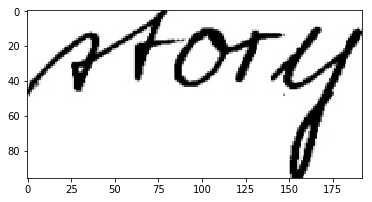

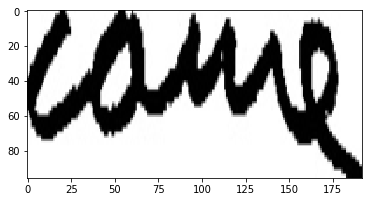

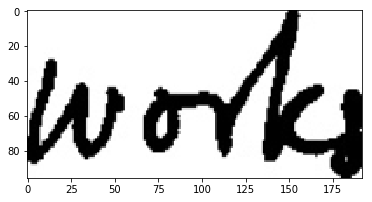

In [10]:
# display a few random images from the dataset:
for _ in range(3):
    random_index = np.random.randint(sanity_test_batch.shape[0])
    plt.figure()
    plt.imshow(sanity_test_batch[random_index])

# In the following cell, I define the computation graph for the network architecture that has been proposed for this task

There is a lot of code written in a single cell, so take a step by step approach towards understanding it

In [12]:
'''
    This cell defines the method required to spawn and return a tensorflow graph for the autoencoder model.
    coded by: Animesh
'''

import tensorflow as tf


myGraph = tf.Graph() #create a new graph object

with myGraph.as_default():
    # define the computations of this graph here:

    # placeholder for the input data batch
    inputs = tf.placeholder(dtype= tf.float32, 
                            shape=(None, data_size[0], data_size[1], data_size[2]), name="inputs")

    # normalized inputs to the range of [-1, 1]
    normalized_inputs = tf.map_fn(lambda x: tf.image.per_image_standardization(x), inputs, 
                                  name="input_normalization")

    
    # We feed the original inputs to the convNet as shown below:
    # encoder layers: 96 x 192
    conv1_1 = tf.layers.conv2d(inputs, 32, [7, 7], strides=(2, 2), 
                            padding="SAME", name="conv_layer1_1", activation=tf.nn.relu)
    # 48 x 96
    conv1_2 = tf.layers.conv2d(conv1_1, 32, [5, 5], strides=(2, 2),
                            padding="SAME", name="conv_layer1_2", activation=tf.nn.relu)
    
    # 24 x 48
    conv1_3 = tf.layers.conv2d(conv1_2, 32, [5, 5], strides=(2, 2),
                            padding="SAME", name="conv_layer1_3", activation=tf.nn.relu)
    # 12 x 24
    conv1_4 = tf.layers.conv2d(conv1_3, 16, [3, 3], strides=(2, 2), 
                            padding="SAME", name="conv_layer1_4", activation=tf.nn.relu)

    # 6 x 12
    
    
    # decoder layers:
    # 6 x 12
    deconv1_1 = tf.layers.conv2d_transpose(conv1_4, 32, [4, 4], strides=(2, 2), 
                                           padding="SAME", name="deconv_layer_1", activation=tf.nn.relu)
    
    # 12 x 24
    deconv1_2 = tf.layers.conv2d_transpose(deconv1_1, 32, [4, 4], strides=(2, 2), 
                                           padding="SAME", name="deconv_layer_2", activation=tf.nn.relu)
    
    # 24 x 48
    deconv1_3 = tf.layers.conv2d_transpose(deconv1_2, 3, [4, 4], strides=(2, 2), 
                                           padding="SAME", name="deconv_layer_3", activation=tf.nn.relu)
    
    # 48 x 96
    deconv1_4 = tf.layers.conv2d_transpose(deconv1_3, 32, [4, 4], strides=(2, 2),
                                           padding="SAME", name="deconv_layer_4", activation=tf.nn.relu)

    # 96 x 192
    deconv1_5 = tf.layers.conv2d_transpose(deconv1_4, 3, [3, 3], strides=(1, 1),
                                           padding="SAME", name="deconv1_5")

    # normalize the predictions i.e deconv1_5 as mentioned above. and then use it for calculating the loss
    normalized_outputs = tf.map_fn(lambda x: tf.image.per_image_standardization(x), deconv1_5, 
                                   name="output_normalization")
    
    output = conv1_4 # get a hook on to the latent representation of the encoder

    y_pred = normalized_outputs # output of the decoder
    y_true = normalized_inputs # input at the beginning

    # define the loss for this model:
    # calculate the loss and optimize the network
    loss = tf.norm(y_pred - y_true, ord="euclidean", name="loss") # claculate the euclidean loss.

    # using Adam optimizer for optimization
    train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss, name="train_op")

In [13]:
# generate a graph of the above model and visualize it.
tensorboard_writer = tf.summary.FileWriter(log_dir, graph=myGraph)

In [14]:
itera = 1
model_name = "Model1"

In [15]:
with tf.Session(graph=myGraph) as sess:
    tf.global_variables_initializer().run()

In [14]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
'''

with tf.Session(graph=myGraph) as sess:
    
    # the path where the model will be saved 
    ''' Currently using the Model no. 1 '''
    model_path = os.path.join(base_model_path, model_name)
    
    # The saver object for saving and loading the model
    saver = tf.train.Saver(max_to_keep=2)
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        # load the weights from the model
        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(new_model_path))
        
    else:
        
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    for ep in range((itera - 1) * no_of_epochs, itera * no_of_epochs):  # start the loop 
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            # log a comment related to the current batch:
            print "current_batch: " + str(batch_n + 1)
            
            # generate the batch images and labels
            batch_images = np.load(os.path.join(processed_data_path, "batch_" + str(batch_n + 1)))
            
            min_batch_size = 1000 # we look at only 1000 images at a time since the machine is small
            
            for index in range(int(len(batch_images) / min_batch_size + 0.5)):
                start = index * min_batch_size
                end = start + min_batch_size
                _, cost = sess.run([train_op, loss], feed_dict={inputs: batch_images[start: end]})
                print('range:{} loss= {}'.format((start, end), cost))
            
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0):
            # save the model trained so far:
            saver.save(sess, os.path.join(new_model_path, model_name), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

epoch: 1
current_batch: 1
range:(0, 1000) loss= 0.810721635818
range:(1000, 2000) loss= 0.812731206417


KeyboardInterrupt: 